In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: DEB


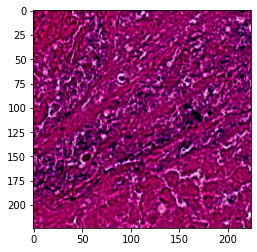

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class MobileNetV1(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()

        def pointwise(input, output, stride):
            return nn.Sequential(
                nn.Conv2d(input, output, 3, stride, 1, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True)
                )

        def depthwise(input, output, stride):
            return nn.Sequential(
                
                nn.Conv2d(input, input, 3, stride, 1, groups=input, bias=False),
                nn.BatchNorm2d(input),
                nn.ReLU(inplace=True),

                
                nn.Conv2d(input, output, 1, 1, 0, bias=False),
                nn.BatchNorm2d(output),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            pointwise(input_channel, 32, 2),
            depthwise(32, 64, 1),
            depthwise(64, 128, 2),
            depthwise(128, 128, 1),
            depthwise(128, 256, 2),
            depthwise(256, 256, 1),
            depthwise(256, 512, 2),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 512, 1),
            depthwise(512, 1024, 2),
            depthwise(1024, 1024, 1),
            nn.AvgPool2d(7)
        )
        self.fc = nn.Linear(1024, n_classes)

        self.model.apply(self.initialw)
        self.fc.apply(self.initialw)

    def initialw(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNetV1(input_channel=3, n_classes=9).to(device)
learning_rate = 0.0002
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("MobileNet9sgd.pth"):
        os.remove("MobileNet9sgd.pth")

      torch.save(model.state_dict(), 'MobileNet9sgd.pth')
      acc=acct


#!cp MobileNet9sgd.pth '/content/drive/My Drive/Histopathology data/'



1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.9473

Test: Average loss: 1.5224, Accuracy: 2436/5400 (45.11%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.4353

Test: Average loss: 1.3458, Accuracy: 2815/5400 (52.13%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.1753

Test: Average loss: 1.0572, Accuracy: 3503/5400 (64.87%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 1.0432

Test: Average loss: 1.0282, Accuracy: 3861/5400 (71.50%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9374

Test: Average loss: 0.8225, Accuracy: 3972/5400 (73.56%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8551

Test: Average loss: 0.6634, Accuracy: 4195/5400 (77.69%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7904

Test: Average loss: 0.8338, Accuracy: 4084/5400 (75.63%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.7150

Test: Average loss: 0.5329, Accuracy: 4505/5400 (83.43%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6541

Test: Average loss: 0.8316, Accuracy: 4357/5400 (80.69%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.6053

Test: Average loss: 0.9698, Accuracy: 4447/5400 (82.35%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5756

Test: Average loss: 1.0483, Accuracy: 4463/5400 (82.65%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5446

Test: Average loss: 0.6733, Accuracy: 4561/5400 (84.46%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4901

Test: Average loss: 0.5065, Accuracy: 4655/5400 (86.20%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4584

Test: Average loss: 0.4670, Accuracy: 4809/5400 (89.06%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4196

Test: Average loss: 0.4096, Accuracy: 4813/5400 (89.13%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3951

Test: Average loss: 1.0012, Accuracy: 4710/5400 (87.22%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3681

Test: Average loss: 0.5403, Accuracy: 4768/5400 (88.30%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3454

Test: Average loss: 0.2848, Accuracy: 4932/5400 (91.33%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3346

Test: Average loss: 0.4594, Accuracy: 4857/5400 (89.94%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3109

Test: Average loss: 0.2841, Accuracy: 5010/5400 (92.78%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3036

Test: Average loss: 0.3491, Accuracy: 4945/5400 (91.57%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2966

Test: Average loss: 0.2804, Accuracy: 5026/5400 (93.07%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2674

Test: Average loss: 0.2643, Accuracy: 5034/5400 (93.22%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2581

Test: Average loss: 0.2366, Accuracy: 5086/5400 (94.19%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2468

Test: Average loss: 0.2355, Accuracy: 5084/5400 (94.15%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2361

Test: Average loss: 0.2454, Accuracy: 5028/5400 (93.11%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2306

Test: Average loss: 0.2343, Accuracy: 5033/5400 (93.20%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2092

Test: Average loss: 0.2620, Accuracy: 5100/5400 (94.44%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2121

Test: Average loss: 0.3340, Accuracy: 5057/5400 (93.65%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2107

Test: Average loss: 0.3005, Accuracy: 5035/5400 (93.24%)



In [ ]:
print(acc)

94.44444444444444


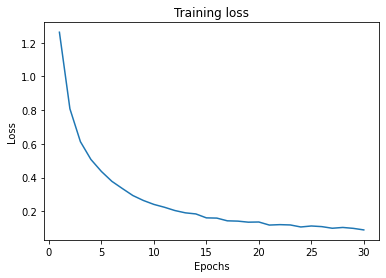

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

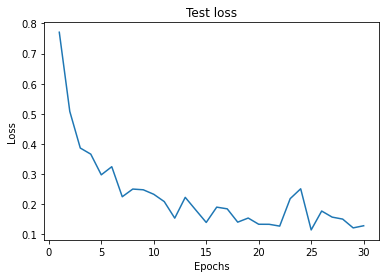

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

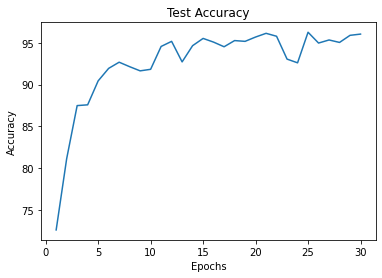

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()